In [1]:
from tabulate import tabulate
import re , os
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from hierarchy import hierarchy_pos

In [2]:
#Global Variables
call_stack = list()
trace_stack = list()
interrupted_functions = list()
waiting_queue = list()

In [3]:
def show_stack_content(tabular_data):
    print(tabulate(tabular_data, headers=['Operation' , 'Current Context' , 'Time'] , tablefmt='fancy_grid'))

In [4]:
def peek(stack):
    if(stack == []):
        return None
    else:
        return stack[-1]

In [5]:
def get_call_stack_trace(operation , functions , time , nodes):
    found_new = False
    found_key = ''
    if(peek(trace_stack) != None):
        index = re.split('call' , str(peek(trace_stack)) , flags=re.IGNORECASE)[1].strip()
        
        if('Return' in operation and index in interrupted_functions):
            interrupted_functions.pop()
            call_stack.pop()

        elif('Call' in operation and 'Call' in str(peek(trace_stack))):
            interrupted_functions.append(index)

        elif('Return' in operation and index not in interrupted_functions):
            call_stack.pop()
            
    if(operation != 'Return'):
        key = re.split('call' , operation , flags=re.IGNORECASE)[1].strip()
        call_stack.append(key)
        
        if(peek(trace_stack) != None):
            index = re.split('call' , str(peek(trace_stack)) , flags=re.IGNORECASE)[1].strip()
            for node in nodes[index]:
                if(node[0] != key and node[0] != ''):
                    found_new = True
                    found_key = key
                else:
                    found_new = False
                    node[0] = key
                    node[1] += 1
                    break
                    
            if(found_new):
                nodes[index].append([found_key , 1])
                    
    return call_stack

In [6]:
def read_log_file(file_path):
    try:
        logs_file = open(file_path , 'r')
        logs_lines = logs_file.read().split('\n')
        tabular_data = list()
        functions = dict()
        nodes = dict()
        code_flow = list() 
        number_of_calls = 0
        number_of_returns = 0
        logs_file_corrupted = False
        
    
        for line in logs_lines:
            logs = line.split(' - ')
            
            if(logs[0].lower() != 'return'):
                fn_name = logs[0].split('Call')[1].strip()
                functions[fn_name] = [0,0,0] #call/return time , inclusive time , exclusive time
                nodes[fn_name] = [['',0]]
                number_of_calls += 1
            else:
                number_of_returns += 1
                
        if(number_of_calls != number_of_returns):
            logs_file_corrupted = True
   
        for i in range(len(logs_lines)-1):
            logs_current = logs_lines[i].split(' - ')
            logs_next = logs_lines[i+1].split(' - ')
            current_context = get_call_stack_trace(logs_current[0] , functions , int(logs_current[1].strip()) , nodes)
            tabular_data.append([logs_current[0] , '<' + ' , '.join(current_context) + '>' , logs_current[1]])
            if(logs_current[0] == 'Return'):
                code_flow.append(['return'])
            code_flow.append([logs_current[1] , peek(current_context) , logs_next[1]])
            
            if(i == len(logs_lines)-2):
                code_flow.append(['return'])
                current_context = get_call_stack_trace(logs_next[0] , functions , int(logs_next[1].strip()) , nodes)
                tabular_data.append([logs_next[0] , '<' + ' , '.join(current_context) + '>' , logs_next[1]])
            
            
            if(logs_current[0]!= 'Return'):
                trace_stack.append(logs_current[0])
            else:
                trace_stack.pop()
        
        return tabular_data , functions , nodes , code_flow , logs_file_corrupted
    
    except IOError:
        print(file_path , 'is not valid!')

In [7]:
def calculate_inclusive_and_exclusive_times(fn_name , code_flow):
    for i in range(len(code_flow)-1):
        item = code_flow[i]

        if(code_flow[i] != ['return']):
            if(item[1] == fn_name and code_flow[i+1] != ['return']):
                if(fn_name not in waiting_queue):
                    functions[fn_name][0] = int(item[0])
                    waiting_queue.append(fn_name)

                functions[fn_name][2] += int(item[2]) - int(item[0])

            #Calculate inclusive and exclusive times for interrupted functions
            elif(item[1] == fn_name and code_flow[i+1] == ['return'] and fn_name in waiting_queue):
                functions[fn_name][1] += int(item[2]) - functions[fn_name][0]
                functions[fn_name][2] += int(item[2]) - int(item[0])
                waiting_queue.pop()
                #functions['a'][0] = int(item[0])

            #Calculate exclusive time for one-shot functions
            elif(item[1] == fn_name and code_flow[i+1] == ['return'] and fn_name not in waiting_queue):
                functions[fn_name][0] = int(item[0])
                functions[fn_name][2] += int(item[2]) - int(item[0])
                
    return functions

In [8]:
def draw_bar_chart(functions , code_flow):
    for fn_name in functions:
        functions = calculate_inclusive_and_exclusive_times(fn_name , code_flow)
    
    functions_names = list()
    inclusive_times = list()
    exclusive_times = list()
    
    #Data to plot
    n_groups = len(functions)
    
    for key in functions:
        inclusive_times.append(functions[key][1])
        exclusive_times.append(functions[key][2])
        
        functions_names.append(key)


    #Create plot
    fig, ax = plt.subplots()
    index = np.arange(n_groups)
    bar_width = 0.35
    opacity = 0.8

    inclusive_bar = plt.barh(index, inclusive_times, bar_width,
    alpha=opacity,
    color='b',
    label='Inclusive Time')

    exclusive_bar = plt.barh(index + bar_width, exclusive_times, bar_width,
    alpha=opacity,
    color='g',
    label='Exclusive Time')

    plt.xlabel('Time')
    plt.ylabel('Functions')
    plt.title('Inclusive vs Exclusive Bar Chart')
    plt.yticks(index + bar_width, functions_names)
    plt.legend()

    plt.tight_layout()
    plt.show()

In [9]:
def draw_CCT(nodes):
    G = nx.DiGraph()
    e_labels = dict()
    max_weight = 0

    for key,node in nodes.items():
        for subnode in node:
            for i in range(len(subnode)//2):
                if(subnode[0] != ''):
                    if(max_weight < subnode[1]):
                        max_weight = subnode[1]

                    G.add_edge(key , subnode[0] , weight=subnode[1])
                    e_labels[(key , subnode[0])] = subnode[1]


    elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d['weight'] >= max_weight]
    esmall = [(u, v) for (u, v, d) in G.edges(data=True) if d['weight'] < max_weight]

    pos = hierarchy_pos(G , None , 1 , 1)

    #Nodes
    nx.draw_networkx_nodes(G, pos, node_size=500 , node_color='g')

    #Edges
    nx.draw_networkx_edges(G, pos, edgelist=elarge,
                           width=4, alpha=0.8 , edge_color='r')
    nx.draw_networkx_edges(G, pos, edgelist=esmall,
                           width=4, alpha=1.0 , style='dashed')

    #labels
    nx.draw_networkx_labels(G, pos , font_size=20, font_family='sans-serif')
    nx.draw_networkx_edge_labels(G, pos , edge_labels=e_labels , font_size=15, font_family='sans-serif')
    
    plt.title('Context Call Tree')
    plt.axis('off')
    plt.show()

In [10]:
path = os.getcwd() + '\Logs.txt'
tabular_data , functions , nodes , code_flow , logs_file_corrupted = read_log_file(path)

╒═════════════╤═══════════════════╤════════╕
│ Operation   │ Current Context   │   Time │
╞═════════════╪═══════════════════╪════════╡
│ Call main   │ <main>            │      0 │
├─────────────┼───────────────────┼────────┤
│ Call a      │ <main , a>        │      5 │
├─────────────┼───────────────────┼────────┤
│ Call b      │ <main , a , b>    │      6 │
├─────────────┼───────────────────┼────────┤
│ Return      │ <main , a>        │      8 │
├─────────────┼───────────────────┼────────┤
│ Call b      │ <main , a , b>    │      9 │
├─────────────┼───────────────────┼────────┤
│ Return      │ <main , a>        │     10 │
├─────────────┼───────────────────┼────────┤
│ Return      │ <main>            │     12 │
├─────────────┼───────────────────┼────────┤
│ Call a      │ <main , a>        │     15 │
├─────────────┼───────────────────┼────────┤
│ Call c      │ <main , a , c>    │     16 │
├─────────────┼───────────────────┼────────┤
│ Return      │ <main , a>        │     18 │
├─────────

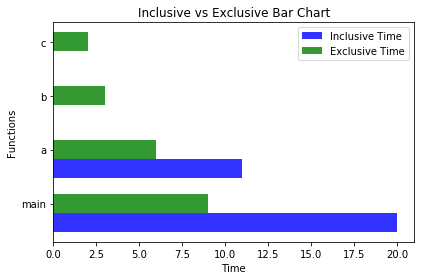

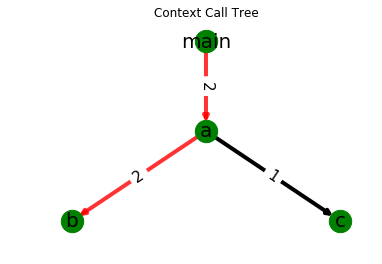

In [11]:
if(not logs_file_corrupted):
    show_stack_content(tabular_data)
    draw_bar_chart(functions , code_flow)
    draw_CCT(nodes)
else:
    print('Logs file is not valid or corrupted!')